# Testing
## Load Libraries

In [1]:
import gym
import copy
import torch
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
import math
import torchvision.transforms as T
import numpy as np
import matplotlib.patches as mpatches
import time
import torch.nn as nn
import itertools


from a3c import AgentA3C
from tqdm import tqdm
from MancalaEnv import MancalaEnv
from game import Game
from randomagent import AgentRandom
from exactagent import AgentExact
from maxagent import AgentMax
from max_min import AgentMinMax

import warnings
warnings.filterwarnings("ignore")

## Load DQN Agent
### Recreate Class

In [3]:
class DQN_replay(nn.Module):
    '''
    This function builds on the DQN class to include the use 
    of a replay memory, where transitions are stored, and randomly
    sampled when the network is updated
    '''
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
        super(DQN_replay, self).__init__()
        self.criterion = torch.nn.MSELoss()
        self.model = torch.nn.Sequential(
                        torch.nn.Linear(state_dim, hidden_dim),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(hidden_dim, hidden_dim*2),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(hidden_dim*2, action_dim)
                )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)



    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def predict(self, state):
        """ Compute Q values for all actions using the DQN. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))

    def _move(self, game):
        state = game.board()
        state2 = state
        if (game._player_one == False):
            state2[7:14] = state[0:7]
            state2[0:7] = state[7:14]
            with torch.no_grad():
                q_values = self.model(torch.Tensor(state2))
            action = torch.argmax(q_values).item()
            return(action+7)
        else:
            with torch.no_grad():
                q_values = self.model(torch.Tensor(state))
            action = torch.argmax(q_values).item()    
            return(action)
        
        

    def replay(self, memory, size, gamma=0.9):
        """New replay function"""
        #Try to improve replay speed
        if len(memory)>=size:
            batch = random.sample(memory,size)
            batch_t = list(map(list, zip(*batch))) #Transpose batch list
            states = batch_t[0]
            actions = batch_t[1]
            next_states = batch_t[2]
            rewards = batch_t[3]
            is_dones = batch_t[4]
        
            states = torch.Tensor(states)
            actions_tensor = torch.Tensor(actions)
            next_states = torch.Tensor(next_states)
            rewards = torch.Tensor(rewards)
            is_dones_tensor = torch.Tensor(is_dones)
        
            is_dones_indices = torch.where(is_dones_tensor==True)[0]
        
            all_q_values = self.model(states) # predicted q_values of all states
            all_q_values_next = self.model(next_states)
            #Update q values
            all_q_values[range(len(all_q_values)),actions]=rewards+gamma*torch.max(all_q_values_next, axis=1).values
            all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]
        
            
            self.update(states.tolist(), all_q_values.tolist())

### Load Saved Model

In [4]:
PATH_DQN = "Replay_dqn_state_dict.pt"
DQN_model = DQN_replay(14,6)
DQN_model.model.load_state_dict(torch.load(PATH_DQN))

<All keys matched successfully>

## Load Actor-Critic Agent

In [5]:
PATH_A3C = "a3c.model"
dtype = torch.FloatTensor
A3C_model = AgentA3C(PATH_A3C,dtype)

## Create Other Agents and Matches

In [6]:
# Create Other Agents
random_agent = AgentRandom()
exact_agent = AgentExact()
minimax_agent = AgentMinMax()
max_agent = AgentMax()

# Create Matches
matches = [(DQN_model,random_agent),
           (DQN_model,exact_agent),
           (DQN_model,minimax_agent),
           (DQN_model,max_agent),
           (DQN_model,A3C_model)]


## Function to Play Matches

In [7]:
def play_matches(player1, player2, num_matches=1):
    '''
    This function runs multiple (num_matcehes) matches between
    two agents as specified in the function parameters.

    Returns: 
    The function returns the wins/losses of the players
    as an array containing 1/0 if the player won or lost respectively
    '''
    player1_wins = []
    player2_wins = []
    for match_ID in tqdm(range(num_matches)):
        game = Game()
        done = False
        while not done:
            # Player 1 Move
            game._player_one = True
            p1_action = player1._move(game)
            game.move(p1_action)

            # End game if move meets win condition
            if game.over():
                break

            # Player 2 Move
            game._player_one = False
            p2_action = player2._move(game)
            game.move(p2_action)
            # End game if move meets win condition
            if game.over():
                break

            # Store game completion flag
            done = game.over()
        winner = game.winner()

        if winner == 1:
            player1_wins.append(1)
            player2_wins.append(0)

        if winner == 2:
            player1_wins.append(0)
            player2_wins.append(1)
            
    return(player1_wins,player2_wins)

## Play Matches vs Other Agents

In [11]:
# Create List to store scores of DQN and opponent(s)
DQN_score = []
opponent_score = []
num_matches = 10
# Play 1000 matches vs each opponent, and store num_wins for each match
for match in matches:
    p1_wins, p2_wins = play_matches(match[0],match[1], num_matches)
    DQN_score.append(sum(p1_wins))
    opponent_score.append(sum(p2_wins))


100%|██████████| 10/10 [00:01<00:00,  8.84it/s]


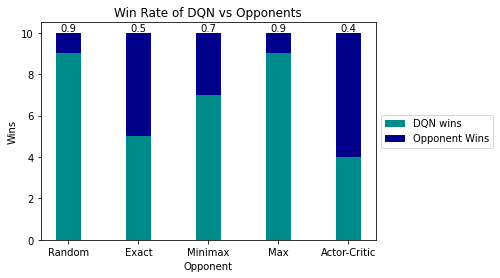

In [12]:
labels = ["Random", "Exact", "Minimax", "Max", "Actor-Critic"]
width = 0.35

fig, ax = plt.subplots()

ax1 = ax.bar(labels, DQN_score, width, color = "darkcyan", label='DQN wins')
ax2 = ax.bar(labels, opponent_score, width, bottom=DQN_score, color = "darkblue",label='Opponent Wins')

ax.set_ylabel('Wins')
ax.set_xlabel("Opponent")
ax.set_title('Win Rate of DQN vs Opponents')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
labels = np.array(DQN_score)

for r1, r2 in zip(ax1, ax2):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r2.get_x() + r2.get_width() / 2., num_matches , h1/num_matches, ha="center", va="bottom", color="black")

plt.show()